Introduction à Pytorch Lightning
======

L'objectif de ce TP est de se familiariser  avec la librairie PyTorch Lightning en réalisant un réseau de neurones capable de classifier des panneaux routiers. Il sera à réaliser en python 3. Les librairies utilisées sont installées sur les machines de l'université, vous pouvez néanmoins les installer sur vos propres machines à l'aide de l'utilitaire `pip` présent par défaut avec python.
	
N'hésitez pas à regarder régulièrement la documentation de ces librairies, des exemples d'utilisation accompagnent généralement l'explication de chaque fonction.

Langage utilisé:
- Python 3: https://docs.python.org/3/

Librairie de math:
- Numpy: https://docs.scipy.org/doc/numpy/reference/

Librairie d'affichage de données:
- Matplotilb: https://matplotlib.org/contents.html

Librairie de Deep Learning
- PyTorch: https://pytorch.org/docs/stable/index.html
- PyTorch Lightning: https://pytorch-lightning.readthedocs.io/en/stable/
- Torchvision: https://pytorch.org/vision/stable/index.html
- Torchmetrics: https://torchmetrics.readthedocs.io/en/stable/


In [1]:
import torch

import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.utils.data import DataLoader, random_split
from pytorch_lightning import loggers as pl_loggers, Trainer
import pytorch_lightning as pl
from pytorch_lightning.utilities.types import STEP_OUTPUT

import torchvision
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

from torchmetrics import Accuracy
import wandb
import os 
import datetime, yaml
from typing import Dict, Iterator, List, Optional, Tuple, TypeVar
import matplotlib.pyplot as plt

C:\Users\a786840\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Nous mettons à votre disposition une base de données contenant des images de quatre types de panneaux différents, ainsi que des images pour l’entraînement et le test du modèle que vous aurez à apprendre.

Le TP se déroulera en quatre étapes. Les trois premières se feront dans ce notebook Jupyter et la dernière étape montrera les capacités de PyTorch Lightning à entraîner des modèles depuis une ligne de commande shell.

Les étapes de ce TP sont les suivantes :
1. Préparer les données et les batches en créant la classe `GTSRBDataModule` qui hérite de
`pl.LightningDataModule`.
2. Construire un modèle de réseau de neurones et les méthodes nécessaires pour l’entraîner en créant la classe `MyModel` qui hérite de `pl.LightningModule`.
3. Entraîner le modèle de l'étape 2 à l’aide des données préparées dans l’étape 1.
4. Utiliser PyTorch Lightning en ligne de commande pour entraîner le modèle à partir d’un
shell.

In [3]:
# timecode to differentiates the runs
now = datetime.datetime.now().strftime("%m-%d_%H-%M-%S")

# load the hyperparameters from a yaml file
with open("./train_config.yaml","r") as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
config

{'project': 'attention',
 'name': 'Cifar10_mobileNetV2',
 'notes': 'Experiment to track model hyperparameters and test wandb platform visualization',
 'tags': ['cifar10', 'mobilenetv2', 'pytorchLightning'],
 'model': 'MobileNetV2',
 'dataset': 'Cifar10',
 'log_dir': './logs',
 'checkpoints_dir': './checkpoints',
 'data_dir': './data/dataset',
 'store_dir': './data/store',
 'optimizer': 'Adam',
 'criterion': 'CrossEntropyLoss',
 'scheduler': 'StepLR',
 'batch_size': 8,
 'learning_rate': 0.001,
 'num_workers': 4,
 'seed': 42,
 'train_size': 0.8,
 'val_size': 0.2,
 'deterministic': False,
 'max_epochs': 5,
 'log_every_n_steps': 1,
 'max_time': '00:00:30:00'}

# 1- Création d'un LigthningDataModule

Nous allons dans ce TP travailler sur une sous-partie du dataset [GTSRB](https://benchmark.ini.rub.de/gtsrb_dataset.html) (*German Traffic Sign Recognition Benchmark*) qui vous est fournis dans les fichiers  `GTSRB_train.zip` et `GTSRB_test.zip`.

Afin de gérer ce dataset, nous allons implémenter une classe `GTSRBDataModule` héritant de [pl.LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html).

Nous allons créer cette classe progressivement dans la suite du TP. Vous reviendriez modifier le bloc suivant au cours des différentes étapes décrites par la suite. 

Commencez par créer la classe `GTSRBDataModule` héritant de `pl.LightningDataModule`. Vous déclarez un constructeur prenant et enregistrant les paramètres suivants: 
- un nom de dossier où est sauvegardé la base de donnée,
- la taille des batches,
- la proportion du trainset à utiliser pour la validation. 

On utilisera pas défaut des batches de 8 images et 10% des images d’entrainement pour la validation.

In [8]:
class GTSRBDataModule(pl.LightningDataModule):
    def __init__(self, data_dir = './data/dataset', store_dir='./data/store', seed = 42, batch_size: int = 32, num_workers = 8, train_proportion = 0.8):
        super().__init__()
        # set batch size and number of workers
        self.batch_size = batch_size
        self.seed = seed
        self.num_workers = num_workers
        self.data_dir = data_dir
        self.store_dir = store_dir
        self.train_prop = train_proportion
        # set up a resize transform
        self.resize = transforms.Resize((224,224))
        # set up a rotation transform from -10 to 10 degrees
        self.rotate = transforms.RandomRotation([-10,10])
        self.transform= transforms.Compose([self.resize, self.rotate, transforms.ToTensor()])

    def prepare_data(self):
        # get the raw dataset files from the store folder and extract it onto the dataset folder
        torchvision.datasets.utils.extract_archive(os.path.join(self.store_dir, 'GTSRB_train.zip'), self.data_dir)
        torchvision.datasets.utils.extract_archive(os.path.join(self.store_dir, 'GTSRB_test.zip'), self.data_dir)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            # load the dataset
            gtsrb_full = torchvision.datasets.ImageFolder(os.path.join(self.data_dir, 'train'), transform=self.transform)
            train_size = int(self.train_prop * len(gtsrb_full))
            val_size = len(gtsrb_full) - train_size
            self.train, self.val = random_split(gtsrb_full, [train_size, val_size] , generator=torch.Generator().manual_seed(self.seed))

        if stage == 'test' or stage is None:
            # load the test dataset
            self.test = torchvision.datasets.ImageFolder(os.path.join(self.data_dir, 'test'), transform=self.transform)

    def train_dataloader(self):
        # sample the full dataset using Dataloader
        return DataLoader(self.train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        #sample the full dataset using Dataloader
        return DataLoader(self.val, batch_size= self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=self.num_workers)

In [9]:
# display function documentation
#torchvision.datasets.utils.extract_archive?

In [10]:
# Création d'un objet datamodule. A relancer à chaque modification de GTSRBDataModule.
datamodule = GTSRBDataModule(
    data_dir=config['data_dir'],
    store_dir=config['store_dir'],
    batch_size=config['batch_size'],
    train_proportion=config['train_size'])

Ajoutez une méthode `prepare_data`. Cette méthode permet la préparation des données. Dans notre cas, elle fera la décompression des archives par la fonction `torchvision.datasets.utils.extrac_archive`, si nécessaire.

Vérifiez que l'appel de la méthode permet bien décompresser les deux fichiers de la base de donnée dans le dossier prévu à cet effet.

In [13]:
datamodule.prepare_data()

In [15]:
!ls data/dataset

test
train


Ajoutez une méthode `setup`. Cette méthode permet de définir des [Datasets Pytorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Pour cela, vous utiliserez la méthode ` torchvision.datasets.ImageFolder` sur les dossiers décompressés précédemment. Vous aurez à préciser les transformations suivantes:
- ramener les images à une taille de 224x224,
- appliquer une rotation aléatoire entre $-10^\circ$ et $10^\circ$ degrés (data augmentation) aux données d'entrainement et de validation uniquement,
- transformer les données en Tensor Pytorch.

La méthode `setup` à un argument nommé `stage`. Regardez dans la documentation son rôle et utilisez-le à bon escient. Cette variable pourra prendre les valeurs `None`, `test` ou `fit`. 

Vous stockerez les datasets dans les attributs: 
- data_train
- data_val
- data_test

Ces trois attributs ne sont pas nécessairement définis en fonction de la valeur de `stage`. On supposera que la valeur `None` permet de tous les définir. 

Appelez la méthode `setup` sans argument. Cette méthode ne retourne rien, mais vous pouvez vérifier la taille des datasets stocker dans les attributs dédiés.

In [11]:
datamodule.setup()
print(f'Taille de train:{len(datamodule.train)}')
print(f'Taille de val:{len(datamodule.val)}')
print(f'Taille de test:{len(datamodule.test)}')

Taille de train:1348
Taille de val:338
Taille de test:84


Écrivez la méthode `train_dataloader`. Cette méthode retourne un dataloader pytorch sur les données de `train`. Vous pourrez utiliser la classe [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) avec les arguments appropriés. 

Vérifiez le bon fonctionnement de votre méthode en affichant toutes les images du premier batch avec `matplotlib`. Vous pourrez utiliser les méthodes `iter` et `next` pour récupérer uniquement le premier batch. 

Vérifiez que la rotation est bien faite sur les images.

In [12]:
# function to plot a grid of images with their labels
def plot_images(fig, image_index, row, col, img, title, textcolor='black'):
    sp = fig.add_subplot(row, col, image_index + 1)
    sp.axis('Off')
    sp.set_title(title, fontsize=16, color=textcolor)
    plt.imshow(img, interpolation=None)

In [33]:
x,y = next(iter(datamodule.train_dataloader()))
print(x.shape, y.shape)

torch.Size([8, 3, 224, 224]) torch.Size([8])


Faites de même pour les méthodes:
- `val_dataloader` : renvoye un `DataLoader` sur les données de validation,
- `test_dataloader` : renvoye un `DataLoader` sur les données de test,
- `predict_dataloader`: renvoye aussi un `DataLoader` sur les données de test.

Vous vérifiez que les données de test n’ont pas de rotation.

In [13]:
def plot_batch(dataloader, title=""):
    x,y = next(iter(datamodule.train_dataloader()))
    # plot a grid of images from the first batch using matplotlib and subfigure
    fig = plt.figure(figsize=(5, 3), layout='constrained')
    # add a main title to the figure
    fig.suptitle(f'Next batch of images from val dataloader', fontsize=16)

    # select a sample of the batch to plot
    for index, (img, label) in enumerate(zip(x, y)):
        # convert tensor image to a numpy array
        rgb_img = img.numpy().transpose((1, 2, 0))
        # get the labels
        label_value = label.numpy()

        # plot the image with its label, using the cifar list to get the label name
        plot_images(fig, index, 2, 4, rgb_img, label_value)

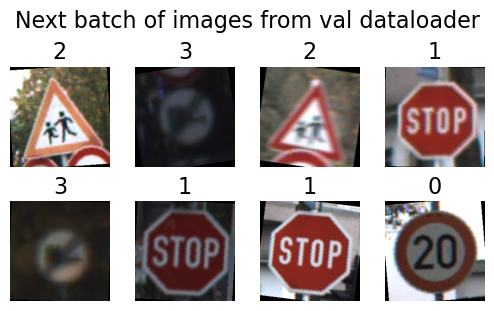

In [14]:
plot_batch(datamodule.train_dataloader(), title="next batch from train dataloader")

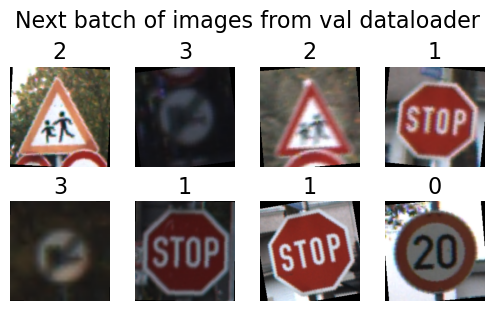

In [15]:
plot_batch(datamodule.val_dataloader(), title="next batch from val dataloader")

In [16]:
plot_batch(datamodule.predict_dataloader(), title="next batch from predict dataloader")

MisconfigurationException: `predict_dataloader` must be implemented to be used with the Lightning Trainer

# 2- Mise en place du réseau de neurone

Nous allons dans cette partie construire le modèle en utilisant le même principe que la partie précédente. 

Commencez par créer la classe `MyModel` héritant de [pl.LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html). Vous définirez un constructeur prenant les arguments suivant: 
- lr: le *learning rate*,
- weight_decay: le poids de la régularisation,
- num_class: le nombre de classe (ici 4),
- *args : d'autres arguments non nommés,
- **kwargs: : d'autres arguments nommés. 

Dans ce constructeur, vous effectuerez les étapes suivantes: 
- sauvegarde des paramètres d'entrées en utilisant `save_hyperparameters`.
- définition d'un réseau de type `resnet18` que vous prendrerez pré-entrainé pour une tâche de classification de type ImageNet.
- Ce classifieur possède 1000 sorties car la classification sur ImageNet se fait sur 1000 classes. Remplacez la couche de classification du réseau chargé (`self.resnet18.fc`) par votre propre couche de classification, qui sera une couche entièrement connectée :`nn.Linear(self.resnet18.fc.weight.shape[1], self.hparams.num_class)`
- Définissez d'un objet de type `nn.CrossEntropyLoss` pour train, val et test. 
- Définissez d'un objet de type `Accuracy` (sur une tache `multiclass`) pour val et test. 

In [20]:
# lightning module using the resnet18 pretrained on ImageNet
class MyModel(pl.LightningModule):
    def __init__(self, lr = 0.001, weight_decay= 0.0001 , num_class = 4, *args, **kwargs):
        super().__init__()
        # save the hyperparameters
        self.save_hyperparameters()
        # load the pretrained resnet18
        self.resnet18 = resnet18(weights=("resnet",ResNet18_Weights))
        # replace the last layer by a linear layer with the right number of classes
        self.resnet18.fc = nn.Linear(self.resnet18.fc.weight.shape[1], self.hparams.num_class)
        # define the loss function
        self.train_loss = nn.CrossEntropyLoss()
        self.val_loss = nn.CrossEntropyLoss()
        self.test_loss = nn.CrossEntropyLoss()

        # define the metrics. One accuracy object separately for train, val and test because of epoch agregations
        self.train_accuracy = Accuracy(task="multiclass", num_classes=self.hparams.num_class)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.hparams.num_class)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.hparams.num_class)

    def forward(self, x):
        # called with self(x)
        return self.resnet18(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.train_loss(y_hat, y)
        # Logging the train loss metric at each step
        self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        # Pass object accuracy rather than the value
        # log the accuracy on the training set
        self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.val_loss(y_hat, y)
        # Logging the val loss metric at each step
        self.log('val_loss', loss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        # log the accuracy on the validation set
        self.log('val_acc', self.val_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        # Best practice : train loss and accuracy on step, val loss and accuracy on epoch

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.test_loss(y_hat, y)
        # Logging the test loss metric at each step
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        # log the accuracy on the test set
        self.log('test_acc', self.test_accuracy, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        return optimizer


In [21]:
# Création d'un objet MyModel. A relancer à chaque modification de MyModel.
model = MyModel()

Définissez une méthode `forward` qui calcule la sortie du réseau en fonction de son entrée. Testez votre méthode avec un tableau aléatoire de taille $(8,3,224,224)$. Vous pouvez utiliser la fonction [torch.rand](https://pytorch.org/docs/stable/generated/torch.rand.html).

In [22]:
# use torch.rand to generate a random tensor of size (8,3,224,224)
x = torch.rand((8,3,224,224))
y_hat = model(x)
y_hat

tensor([[-0.8331, -0.6118, -1.1582,  0.0021],
        [-0.7259, -0.3490, -0.6612, -0.6919],
        [-0.2083, -0.6403, -0.7231,  0.0880],
        [-1.4272, -0.4111, -0.4272, -0.1239],
        [-0.9102, -0.4714, -1.2582, -0.8296],
        [-0.8438, -0.5962, -0.6701, -0.1053],
        [-0.2849, -0.8746, -1.1683, -0.4118],
        [-0.0859, -1.3051, -1.2720, -0.3208]], grad_fn=<AddmmBackward0>)

Définissez la méthode `training_step`. Cette méthode calcul la sortie du réseau pour un batch donné puis évalue la fonction de coût (qu'elle retournera). Vous effectuerez également les logs de la fonction de coût.  

Récupérez le premier batch avec le `datamodule` de la première partie et testez votre fonction. Le deuxième paramètre sera mis à 0 pour ce test.

Vérifiez que votre fonction retourne bien une valeur pour la loss.

In [23]:
x,y = next(iter(datamodule.train_dataloader()))
loss = model.training_step((x,y),0)
loss

C:\Users\a786840\Anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\core\module.py:416: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


tensor(1.3262, grad_fn=<NllLossBackward0>)

Définissez la méthode `validation_step` effectuant le traitement d'un batch sur les données de validation. Cette méthode est très similaire à la précédente hormis le fait qu'elle ne retourne rien et log en plus les performances en *accuracy*.

Testez la méthode en la lançant. Il ne devrait rien s'afficher, mais vous ne devez pas avoir d'erreur. 

In [74]:
x,y = next(iter(datamodule.train_dataloader()))
model.validation_step((x,y),0)

Définissez de la même manière que précédemment la méthode `test_step`.

In [78]:
x,y = next(iter(datamodule.train_dataloader()))
test_loss = model.test_step((x,y),0)
print(test_loss)

tensor(1.4342, grad_fn=<NllLossBackward0>)


Définissez la méthode `configure_optimizers` qui retourne le ou les optimiseurs choisis pour entrainer le réseau. Nous utiliserons ici un optimiser d'[Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

Lancez votre méthode pour en vérifier le bon fonctionnement.

In [83]:
model.configure_optimizers()

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0.1
)

# 3- Entraînement du modèle et test

Nous avons précédemment défini tous les éléments important pour apprendre notre réseau. 
En utilisant un objet de type [Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html), faites un apprentissage sur 5 époques (vous pouvez faire plus d'époque pour de meilleurs résultats).

In [24]:
# login to wandb
connected = wandb.login()

wandb: Currently logged in as: william-pantry. Use `wandb login --relogin` to force relogin


In [25]:
if connected:
    # start a wandb run
    wandb.init(
        project=config['project'],
        name=f"{config['name']}_{now}",
        notes=config['notes'],
        tags=config['tags'],
        config=config,
        dir=config['log_dir'],
        )

    # define a logger
    logger = pl_loggers.WandbLogger()

C:\Users\a786840\Anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\loggers\wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [26]:
# start training
trainer = Trainer(
    #accumulate_grad_batches= 4, # Accumulation des gradiens sur 4 batches pour des cartes graphiques avec peu de mémoire,
    deterministic= config['deterministic'], # True pour la reproductibilité attention ça ne force pas les generateurs aléatoires à être déterministes
    # et ça ralenti la carte graphique
    #check_val_every_n_epoch= 10, # On test le modèle que sur 10 epoch pour accelerer les calculs
    max_epochs=config['max_epochs'], # On fait 100 epoch au max
    max_time=config['max_time'], # On fait 30 minutes au max
    log_every_n_steps=config['log_every_n_steps'], # On log les résultats à chaque step pour visualiser la validation et traning loss et accuracy avant la première epoch
    #precision=16, # On utilise des nombres en 16 bits pour accelerer les calculs, diminuer la taille
    #gpus=1,
    #accelerator="cuda", devices=find_usable_cuda_devices(2), # On utilise une carte graphique
    logger=logger,
    #callbacks=[checkpoint_callback, batchReportCallback()]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
trainer.fit(model, datamodule)


  | Name           | Type               | Params
------------------------------------------------------
0 | resnet18       | ResNet             | 11.2 M
1 | train_loss     | CrossEntropyLoss   | 0     
2 | val_loss       | CrossEntropyLoss   | 0     
3 | test_loss      | CrossEntropyLoss   | 0     
4 | train_accuracy | MulticlassAccuracy | 0     
5 | val_accuracy   | MulticlassAccuracy | 0     
6 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.714    Total estimated model params size (MB)


C:\Users\a786840\Anaconda3\envs\pytorch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Epoch 0:  80%|███████▉  | 169/212 [05:58<01:31,  2.12s/it, loss=0.17, v_num=5n96, train_loss=1.770]    
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|███████▉  | 169/212 [06:10<01:34,  2.19s/it, loss=0.112, v_num=5n96, train_loss=0.268, val_loss=0.00223, val_acc_epoch=0.000]    
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|███████▉  | 169/212 [05:41<01:26,  2.02s/it, loss=0.0043, v_num=5n96, train_loss=0.0262, val_loss=6.04e-5, val_acc_epoch=0.000]   
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|███████▉  | 169/212 [05:22<01:21,  1.91s/it, loss=0.0017, v_num=5n96, train_loss=0.00788, val_loss=7.52e-5, val_acc_epoch=0.000]  
Validation: 0it [00:00, ?it/s]
Epoch 4:  24%|██▎       | 50/212 [02:03<06:39,  2.47s/it, loss=0.00119, v_num=5n96, train_loss=0.000596, val_loss=5.53e-5, val_acc_epoch=0.000] 


KeyboardInterrupt



En utilisant la méthode `test` de `Trainer` précédent, obtenez les performances sur la base de test.

In [ ]:
trainer.test()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /Users/lechervy/Documents/cours/cours/global/Journée Formation/journees-de-formation/Formation_Deep_doctorants/TP1_lightning/lightning_logs/version_13/checkpoints/epoch=4-step=950.ckpt
Loaded model weights from the checkpoint at /Users/lechervy/Documents/cours/cours/global/Journée Formation/journees-de-formation/Formation_Deep_doctorants/TP1_lightning/lightning_logs/version_13/checkpoints/epoch=4-step=950.ckpt
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │    0.04111113399267197    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.04111113399267197, 'test_acc': 1.0}]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /Users/lechervy/Documents/cours/cours/global/Journée Formation/journees-de-formation/Formation_Deep_doctorants/TP1_lightning/lightning_logs/version_13/checkpoints/epoch=4-step=950.ckpt
Loaded model weights from the checkpoint at /Users/lechervy/Documents/cours/cours/global/Journée Formation/journees-de-formation/Formation_Deep_doctorants/TP1_lightning/lightning_logs/version_13/checkpoints/epoch=4-step=950.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9349112510681152     │
│         val_loss          │    0.1731763631105423     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.1731763631105423, 'val_acc': 0.9349112510681152}]

# 4- Utilisation de la ligne de commande

Généralement, on ne lance pas de calcul important dans un `notebook`. On les utilise pour debuger les codes et pour la visualisation. Nous allons donc voir dans cette partie comment définir les fichiers pour un lancement sur serveur. 



Définissez un fichier `my_dataset.py` contenant la définition de `GTSRBDataModule`. N'oubliez pas de mettre les imports appropriés.

Définissez un fichier `my_model.py` contenant la définition de `MyModel`. N'oubliez pas de mettre les imports appropriés.

Définissez un fichier `main.py` contenant un `main` python et créant un objet de type [LightningCLI](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.cli.LightningCLI.html?highlight=lightningcli#lightning.pytorch.cli.LightningCLI) avec notre dataset et notre model.

Vous pouvez maintenant lancer votre code avec la commande : 

```
python3 main.py fit --trainer.max_epochs 5
```

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py:39: UserWarning: No seed found, seed set to 2366542076
  rank_zero_warn(f"No seed found, seed set to {seed}")
Global seed set to 2366542076
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params
------------------------------------------------
0 | resnet18   | ResNet           | 11.2 M
1 | loss_train | CrossEntropyLoss | 0     
2 | loss_val   | CrossEntropyLoss | 0     
3 | loss_test  | CrossEntropyLoss | 0     
4 | acc_val    | Accuracy         | 0     
5 | acc_test   | Accuracy         | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.714    Total estimated model params size (MB)
Sanity Checking: 0it [00:00, ?it/s]/Library/Frameworks/Python.fr

Vous pouvez sauvegarder tous les paramètres de configuration dans un fichier yaml pour pouvoir facilement les modifier et les utiliser par la suite à l'aide de la commande suivante: 

In [6]:
!python3 main.py fit --trainer.max_epochs 5 --print_config >config.yaml

Il vous suffit ensuite de lancer votre script avec les paramètres de configuration avec le code suivant:

In [7]:
!python3 main.py fit --confi config.yaml

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py:39: UserWarning: No seed found, seed set to 3559756612
  rank_zero_warn(f"No seed found, seed set to {seed}")
Global seed set to 3559756612
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params
------------------------------------------------
0 | resnet18   | ResNet           | 11.2 M
1 | loss_train | CrossEntropyLoss | 0     
2 | loss_val   | CrossEntropyLoss | 0     
3 | loss_test  | CrossEntropyLoss | 0     
4 | acc_val    | Accuracy         | 0     
5 | acc_test   | Accuracy         | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.714    Total estimated model params size (MB)
Sanity Checking: 0it [00:00, ?it/s]/Library/Frameworks/Python.fr

En utilisant l'attribut `ckpt_path` de la méthode `fit` de `Trainer` recharger le modèle que vous avez appris à l'aide de la console (qui a été enregistré dans le dossier `lightning_logs`) et vérifier ses performances sur test. Attention, si vous ne préciser pas le nombre d'époque l'apprentissage continuera depuis l'endroit où vous étiez arrêté en console.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at lightning_logs/version_8/checkpoints/epoch=4-step=240.ckpt
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:337: UserWarning: The dirpath has changed from '/Users/lechervy/Documents/cours/cours/global/Journée Formation/journees-de-formation/Formation_Deep_doctorants/TP1_lightning/lightning_logs/version_8/checkpoints' to '/Users/lechervy/Documents/cours/cours/global/Journée Formation/journees-de-formation/Formation_Deep_doctorants/TP1_lightning/lightning_logs/version_15/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
  warnings.warn(

  | Name       | Type             | Params
----------

Sanity Checking: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
Restoring states from the checkpoint path at /Users/lechervy/Documents/cours/cours/global/Journée Formation/journees-de-formation/Formation_Deep_doctorants/TP1_lightning/lightning_logs/version_8/checkpoints/epoch=4-step=240.ckpt
Loaded model weights from the checkpoint at /Users/lechervy/Documents/cours/cours/global/Journée Formation/journees-de-formation/Formation_Deep_doctorants/TP1_lightning/lightning_logs/version_8/checkpoints/epoch=4-step=240.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7976190447807312     │
│         test_loss         │    0.46025463938713074    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.46025463938713074, 'test_acc': 0.7976190447807312}]